### Neutron refletcivity analysis of a triblock co-polymer (A7_B50_A7) monolayer deposited onto a silicon crystal    

This is a script that uses the Refnx python package to fit neutron reflectometry data. The script generates a slab model of the interface where each layer is defined by 4 parameters:  the thickness, the scattering length density (SLD), the volume fraction of solvent and the interfacial roughness. The script allows to constrain together multiple datasets (constrasts) measured against liquids bulk phases with different SLDs. This is achieved by mixing water (H2O) and heavy water (D2O) in four ratios: 100% H2O (SLD of -0.56) 38% D2O (SLD of 2) 66% D2O (SLD of 4) and 100% D2O (SLD of 6.35).   

Information on the RefNX python library can be found here: https://refnx.readthedocs.io/en/latest/

The sample in object is a monolayer formed by a triblock co-polymer made of three parts, two outer hydrophilic regions formed of 7 repeats of PMOXA and an inner hydrophobic chain fomred of 50 repeats of PDMS. The monolayers is deposited onto a silicon crystal covered by a thin siicon oxide native layer of about 2 nm.

A7 = PMOXA7 = HO(CH2)14(CH3)7(NCO)7 | Calculated SLD = 1.09 e-6 Å^-2

B50 = PDMS50 = Si50(CH3)100O49 | Calculated SLD = 0.06 e-6 Å^-2


### Model Description:

The slab model is composed of 6 slabs which represent the following layers:

Silicon (semi infinite layer) | Silicon Oxide | A7 Head | B50 Tail | A7 Head | Solvent (semi infinite layer)

- The model was chosen to minimise the number of parameters whilst still describing a physically reasonable interfacial structure
- The two A7 Head regions are defined by the same parameters for thickness, SLD and solvent volume fraction and are simply repeated on both ends of the Tail region
- A common roughness parameter is used to describe the roughness of the triblock monolayer, and a separate roughness value describes the roughness of the substrate
- All the SLD parameters were fixed to the values calculated for the respective materials: Silicon = 2.07; Silicon Oxide = 3.47; A7 Head = 1.09; B50 Tail = 0.06. All SLD values are in units of 10e-6 Å^-2



In [2]:
# use matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path

import refnx, scipy

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, Parameters, process_chain, Transform, load_chain, possibly_create_parameter

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet, Component, sld_profile

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

import periodictable
from multiprocessing import Pool

# version numbers used in this analysis
refnx.version.version, scipy.version.version, np.version.version


('0.1.31', '1.10.0', '1.24.1')

In [3]:
# Loading the datasets
data_d2o = ReflectDataset('S4_D2O.mft')
data_d2o.name = "D2O_dataset"

data_fmw = ReflectDataset('S4_4MW.mft')
data_fmw.name = "4MW_dataset"

data_smw = ReflectDataset('S4_2MW.mft')
data_smw.name = "SMW_dataset"

data_h2o = ReflectDataset('S4_H2O.mft')
data_h2o.name = "H2O_dataset"


In [4]:
#Defining the interfacial structure, and calculating the SLD (rho) by taking into account the hydration in each layer
class Monolayer(Component):
    def __init__(self, *pars):
        super().__init__(name='monolayer')
        
        self.pnames = ['sio2_thick', 'sio2_sld', 'sio2_hydration', 'sio2_rough', 
                       'head_thick', 'head_sld', 'head_hydration', 
                       'tails_thick','tails_sld', 'tails_hydration', 
                       'outer_rough'
                  ]
        self._pars = [possibly_create_parameter(m, name=pname) for pname, m in zip(self.pnames, pars)]        

        assert len(self._pars) == 11
        assert len(self.pnames) == 11
        
        for pname, m in zip(pnames, self._pars):
            setattr(self, pname, m)
    
        
        self._parameters = Parameters(data = self._pars, name=self.name)

    @property
    def parameters(self):
        return self._parameters
    
    def slabs(self, structure=None):
        """
        Slab representation of this component. See :class:`Component.slabs`
        """
        solvent = complex(structure.solvent)
        
        rhoSio2 = self.sio2_hydration.value * solvent
        rhoSio2 += (1 - self.sio2_hydration.value) * self.sio2_sld.value
    
        # Account for polymer film hydration
        
        rhoTails = self.tails_hydration.value * solvent 
        rhoTails += (1 - self.tails_hydration.value) * self.tails_sld.value        
        
        rhoHead = self.head_hydration.value * solvent
        rhoHead += (1 - self.head_hydration.value) * self.head_sld.value
    

        orough = self.outer_rough.value
        sub_rough = self.sio2_rough.value
        
        
        #Define interfacial slab structure
        
        monolayer = np.array([
            [self.sio2_thick.value, np.real(rhoSio2), np.imag(0), sub_rough, 0],
            [self.head_thick.value, np.real(rhoHead), np.imag(0), sub_rough, 0],
            [self.tails_thick.value, np.real(rhoTails), np.imag(0), orough, 0],
            [self.head_thick.value, np.real(rhoHead), np.imag(0), orough, 0],
        ], dtype=float)
    
        return np.r_[monolayer]

In [5]:
#Assign values to parameters and define bounds within which they are allowed to vary during the fit

pnames = ['sio2_thick', 'sio2_sld', 'sio2_hydration', 'sio2_rough', 
          'head_thick', 'head_sld', 'head_hydration', 
          'tails_thick','tails_sld', 'tails_hydration', 
          'outer_rough'                                      
                  ]

pars = [0] * len(pnames)

m = Monolayer(*pars)

# Set bounds, etc, on each of the parameters
m.sio2_thick.setp         (18, vary=True, bounds=(8, 30))
m.sio2_sld.setp           (3.47, vary=False)
m.sio2_hydration.setp     (0.02, vary=True, bounds=(0, 0.2))
m.sio2_rough.setp         (3, vary=True, bounds=(3, 8))

m.head_thick.setp         (20, vary=True, bounds=(10, 50))
m.head_sld.setp           (1.09, vary=False)
m.head_hydration.setp     (0.6, vary=True, bounds=(0, 1))

m.tails_thick.setp        (161, vary=True, bounds=(100, 200))
m.tails_sld.setp          (0.06, vary=False)
m.tails_hydration.setp    (0.3, vary=True, bounds=(0, 1))

m.outer_rough.setp        (5, vary=True, bounds=(3, 8))


In [6]:
# Define SLDs of the bulk phases 
si = SLD(2.07,   'Si')

d2o = SLD(6.36,  'D2O')
h2o = SLD(-0.56, 'H2O')
smw = SLD(2.07,  'SMW')
fmw = SLD(4.00,  '4MW')

d2o.real.setp(6.25, bounds=(6, 6.36), vary=True)
d2o.real.name='D2O SLD'

fmw.real.setp(4, bounds=(3.8, 4.2), vary=True)
fmw.real.name='4MW SLD'

smw.real.setp(2.07, bounds=(1.6, 2.2), vary=True)
smw.real.name='SMW SLD'

h2o.real.setp(-0.56, bounds=(-0.56, -0.1), vary=True)
h2o.real.name='H2O SLD'

#Define the structure of the sample in the four solution contrasts. The roughness of the solvent layer is set to the be
s_d2o = si | m | d2o(0, m.outer_rough)
s_fmw = si | m | fmw(0, m.outer_rough)
s_smw = si | m | smw(0, m.outer_rough)
s_h2o = si | m | h2o(0, m.outer_rough)

In [7]:
# Defining parameters for background and scale factor and 
scale = Parameter(1, 'Common scale factor')
scale.setp(1, bounds=(0.8, 1.2), vary=True)

bkg1 = Parameter(1e-6, 'Bkg1')
bkg1.setp(1e-6, bounds=(1e-8,1e-6), vary=False)

bkg2 = Parameter(1e-6, 'Bkg2')
bkg2.setp(1e-6, bounds=(1e-8, 1e-6), vary=False)

bkg3 = Parameter(1e-6, 'Bkg3')
bkg3.setp(1e-6, bounds=(1e-8, 1e-6), vary=False)

bkg4 = Parameter(1e-6, 'Bkg4')
bkg4.setp(2e-6, bounds=(1e-8, 1e-6), vary=False)

#Assign scale factors, background parameters and resolution to the calculated reflectivities

model_d2o = ReflectModel(s_d2o, scale=scale, bkg=bkg1, dq=7, dq_type='constant')
model_fmw = ReflectModel(s_fmw, scale=scale, bkg=bkg2, dq=7, dq_type='constant')
model_smw = ReflectModel(s_smw, scale=scale, bkg=bkg3, dq=7, dq_type='constant')
model_h2o = ReflectModel(s_h2o, scale=scale, bkg=bkg4, dq=7, dq_type='constant')


In [8]:
#Each Objective combines a model, representing the theoretical construct describing the slab interface, with the corresponding measured datasets
objective_d2o = Objective(model_d2o, data_d2o)
objective_fmw = Objective(model_fmw, data_fmw)
objective_smw = Objective(model_smw, data_smw)
objective_h2o = Objective(model_h2o, data_h2o)

#The function used during fitting will optimize a weighted sum of the residuals essentially giving more importance to datapoints with smaller uncertainties 
objective_h2o.weighted =  objective_smw.weighted = objective_fmw.weighted = objective_d2o.weighted = True 

#Create a global objective to fit simultaneously the 4 objectives with a shared set of parameters
global_objective = GlobalObjective([objective_d2o, objective_fmw, objective_smw, objective_h2o])

In [10]:
#Display the structure of the interface and its initial values in an array containing values for: [thickness, real SLD, imaginary SLD, roughness, hydration]
#Note that the hydration parameter here is fixed to zero as the solvent volume fraction is included in the real SLD as described in the paracini Component 
s = Structure(solvent=d2o) 
m.slabs(s)

array([[ 18.    ,   3.5256,   0.    ,   3.    ,   0.    ],
       [ 20.    ,   4.186 ,   0.    ,   3.    ,   0.    ],
       [161.    ,   1.917 ,   0.    ,   5.    ,   0.    ],
       [ 20.    ,   4.186 ,   0.    ,   5.    ,   0.    ]])

In [11]:
#The global_objective is passed to the CurveFitter class which handles the fitting process
fitter = CurveFitter(global_objective)

In [12]:
#The .fit method executes the fitting with the specified 'differential evolution' minimization algorithm, 
#The population size determines how many candidate solutions are explored in each iteration of the 'differential evolution' algorithm.
fitter.fit('differential_evolution', popsize=10);

85it [01:06,  1.28it/s]


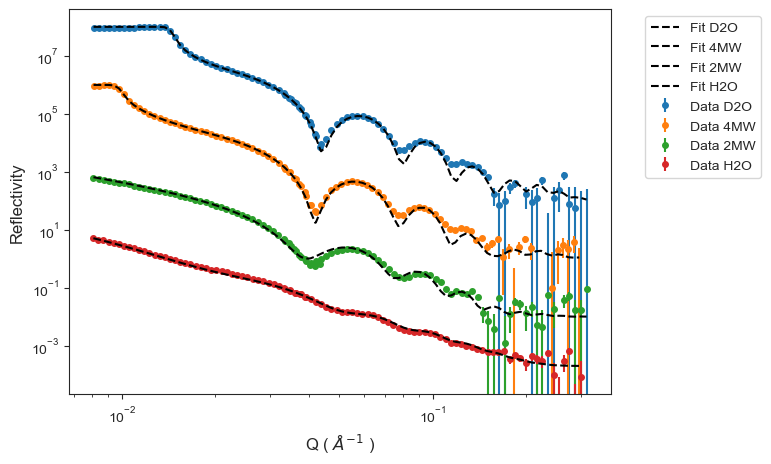

In [29]:
#Plot the obtained fits and corresponding datasets

# Define the offsets for each dataset
offsets = [8, 6, 4, 2]

marksize = 4
color = 'black'

# Define the scaling function
def scale_y(y, x):
    return y  # or 'y * x**4' for R*Q^4

# Function to apply vertical offset
def apply_vertical_offset(y, offset):
    return y * 10**offset

fig1 = plt.figure(figsize=(7, 5))

# Define a list of objectives and labels
objectives = [objective_d2o, objective_fmw, objective_smw, objective_h2o]
labels = ['D2O', '4MW', '2MW', 'H2O']

# Loop over each objective and plot
for i, objective in enumerate(objectives):
    x, y, y_err = objective.data.x, objective.data.y, objective.data.y_err
    scaled_y = scale_y(apply_vertical_offset(y, offsets[i]), x)
    scaled_y_err = scale_y(apply_vertical_offset(y_err, offsets[i]), x)
    scaled_model_y = scale_y(apply_vertical_offset(objective.model(x), offsets[i]), x)

    plt.errorbar(x, scaled_y, scaled_y_err, label=f'Data {labels[i]}', fmt='o', markersize=marksize)
    plt.plot(x, scaled_model_y, label=f'Fit {labels[i]}', linestyle='--', color=color, zorder=10)

plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Q ( $Å^{-1}$ )', fontsize=12)
plt.ylabel('Reflectivity', fontsize=12)

plt.show()

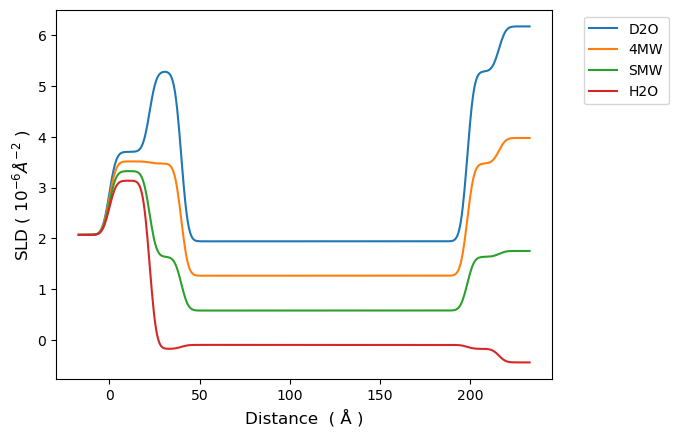

In [14]:
#Plot the corresponding SLD profiles

fig2, ax = plt.subplots()
ax.plot(*s_d2o.sld_profile(), label='D2O')
ax.plot(*s_fmw.sld_profile(), label='4MW')
ax.plot(*s_smw.sld_profile(), label='SMW')
ax.plot(*s_h2o.sld_profile(), label='H2O')

ax.set_ylabel("SLD ( $10^{-6} \AA^{-2}$ )", fontsize = 12)
ax.set_xlabel("Distance  ( Å )", fontsize = 12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [16]:
#Display the structure of the interface with the optimized values obtained after the fitting 
s = Structure(solvent=d2o) 
m.slabs(s)

array([[ 22.33662785,   3.70146415,   0.        ,   3.        ,
          0.        ],
       [ 17.55538133,   5.28191507,   0.        ,   3.        ,
          0.        ],
       [158.56462629,   1.94242104,   0.        ,   3.        ,
          0.        ],
       [ 17.55538133,   5.28191507,   0.        ,   3.        ,
          0.        ]])

In [17]:
#Display the values for all the parameters after the fitting for all Objectives
print(global_objective)

_______________________________________________________________________________

--Global Objective--
________________________________________________________________________________
Objective - 5260025760
Dataset = D2O_dataset
datapoints = 103
chi2 = 5270.577381723475
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'Common scale factor', value=0.974914 +/- 0.00128, bounds=[0.8, 1.2]>
<Parameter:    'Bkg1'     , value=1e-06 (fixed)  , bounds=[1e-08, 1e-06]>
<Parameter:'dq - resolution', value=7 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
_______________________________________________________________________

In [18]:
#Generates 2000 samples of the parameter space keeping one every 100th to reduce correlation
res = fitter.sample(20, nthin=100, pool=1)

100%|███████████████████████████████████████| 2000/2000 [27:16<00:00,  1.22it/s]


In [19]:
#Display the values for all the parameters after the fitting for all Objectives
print(global_objective)

_______________________________________________________________________________

--Global Objective--
________________________________________________________________________________
Objective - 5260025760
Dataset = D2O_dataset
datapoints = 103
chi2 = 5267.439358258548
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'Common scale factor', value=0.974818 +/- 0.00125, bounds=[0.8, 1.2]>
<Parameter:    'Bkg1'     , value=1e-06 (fixed)  , bounds=[1e-08, 1e-06]>
<Parameter:'dq - resolution', value=7 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
_______________________________________________________________________

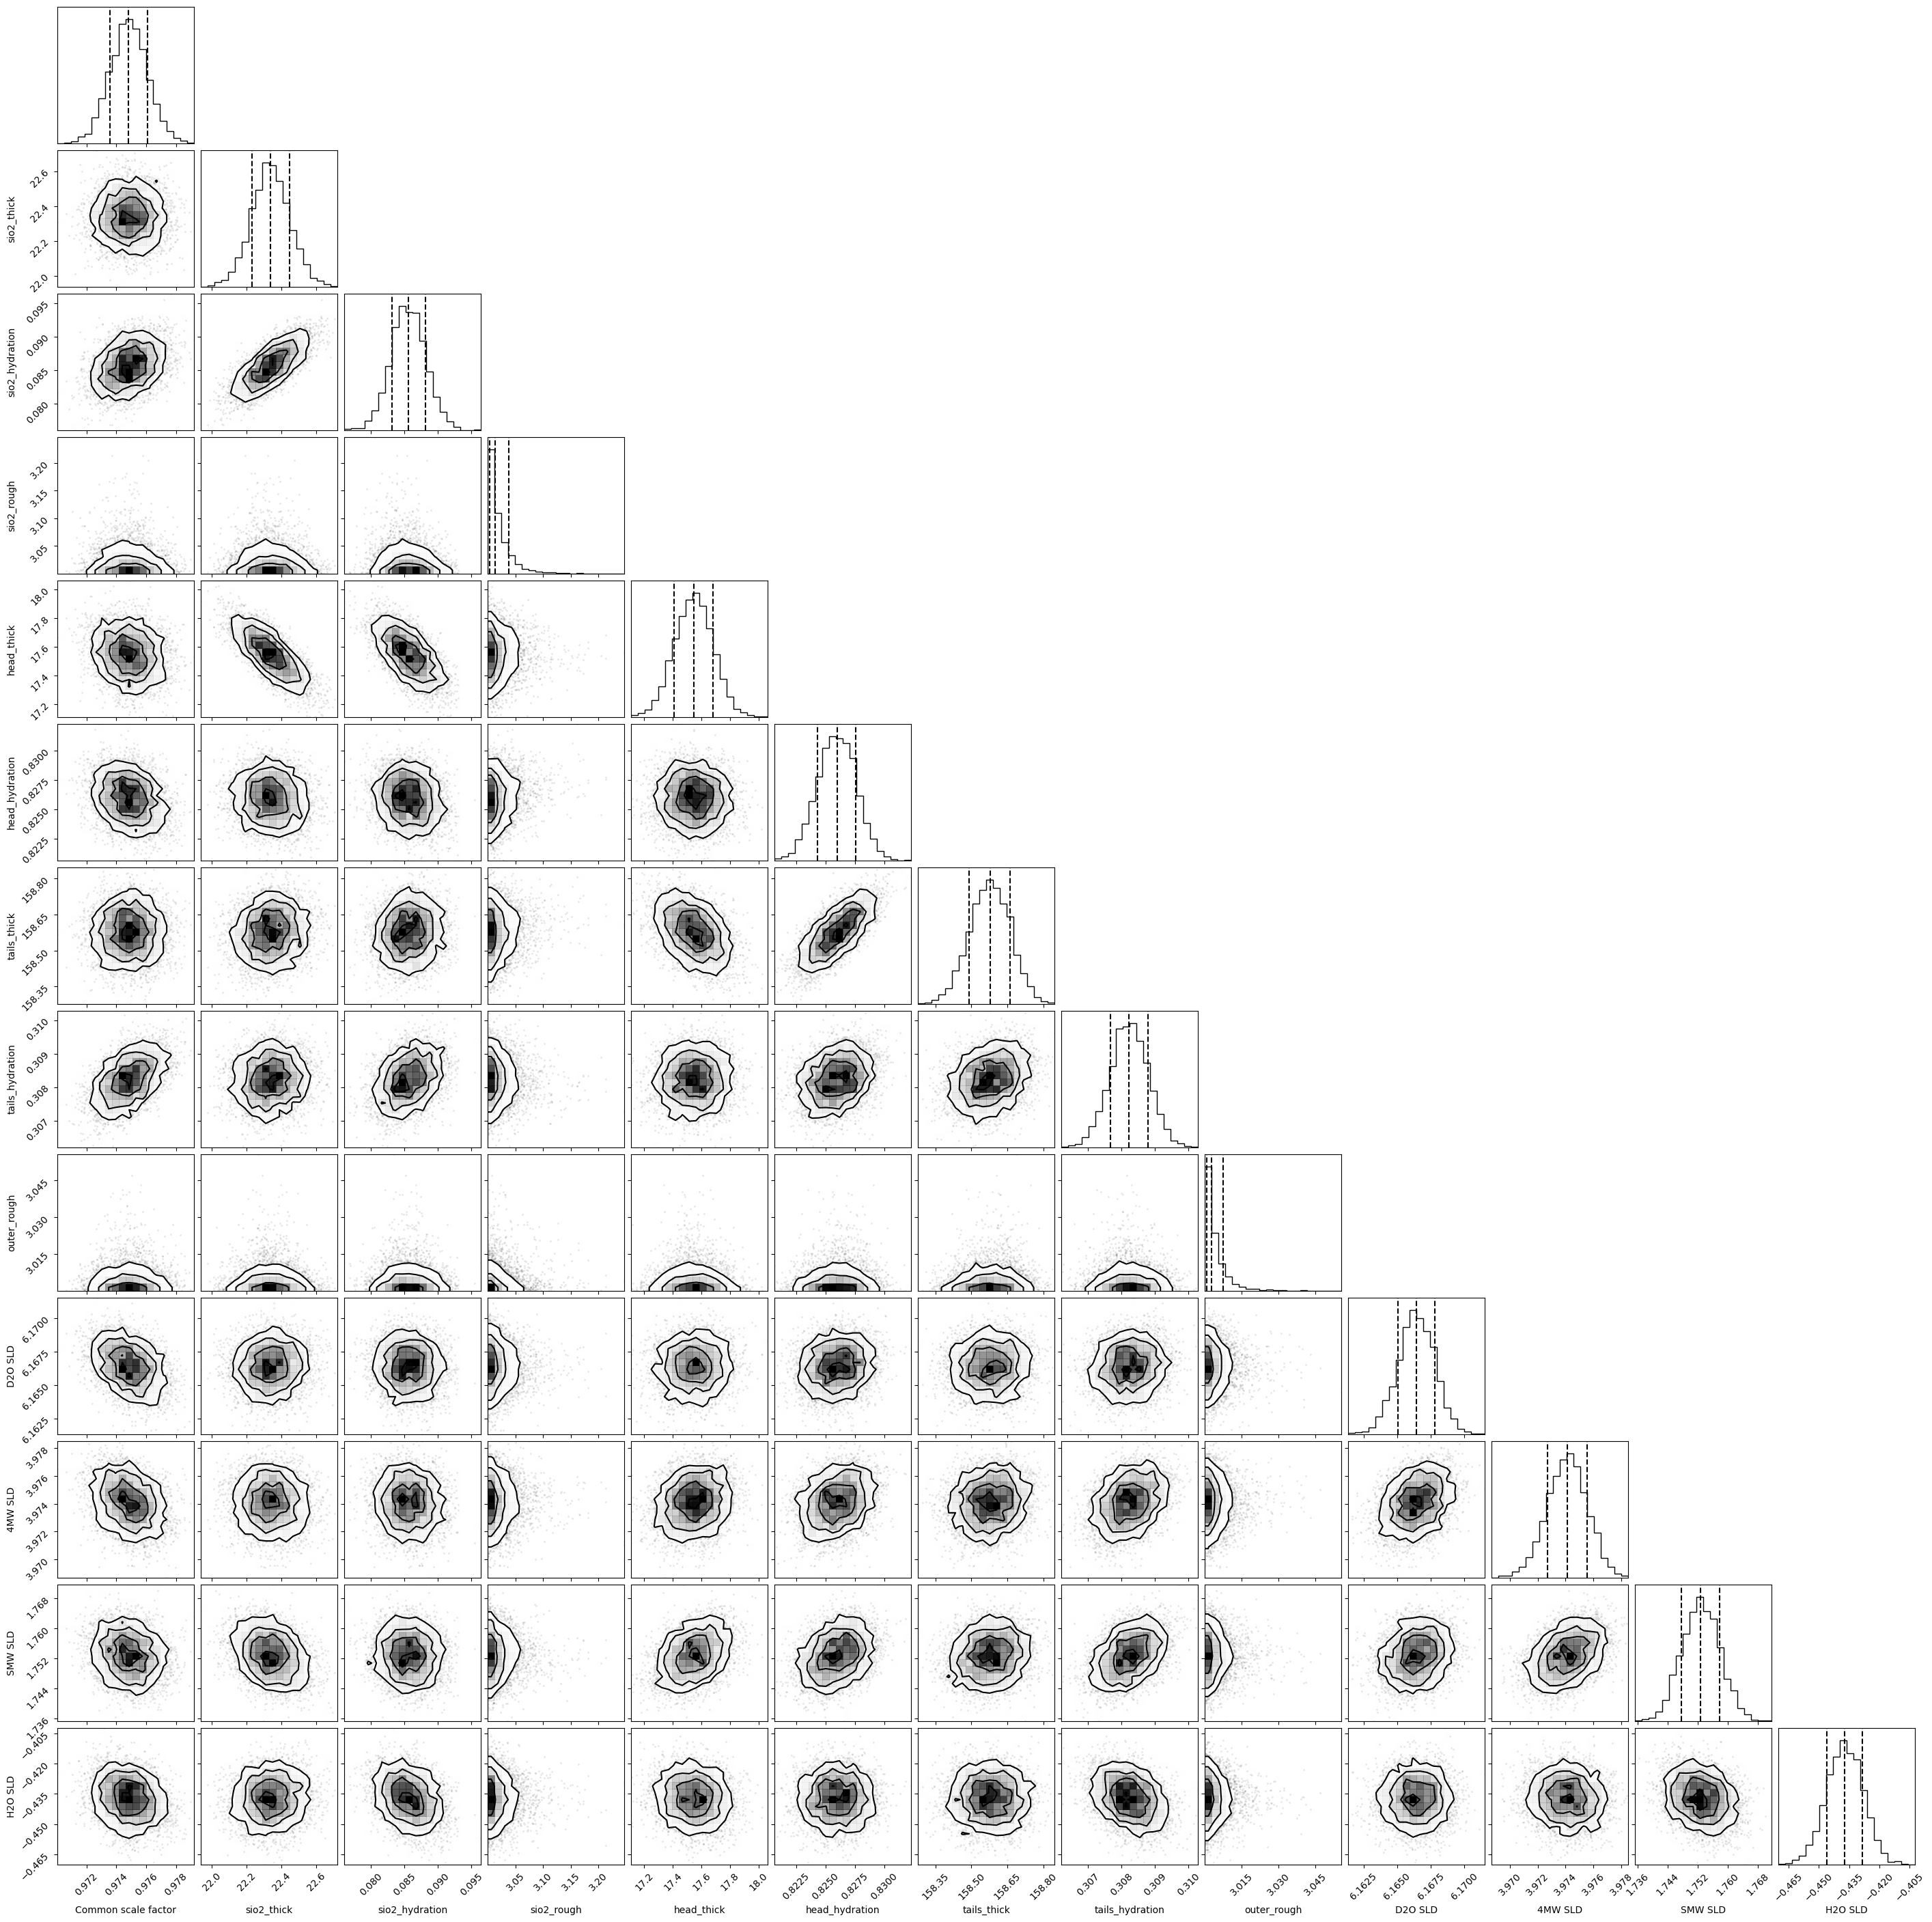

In [20]:
global_objective.corner();
# plt.savefig('CornerPlot')

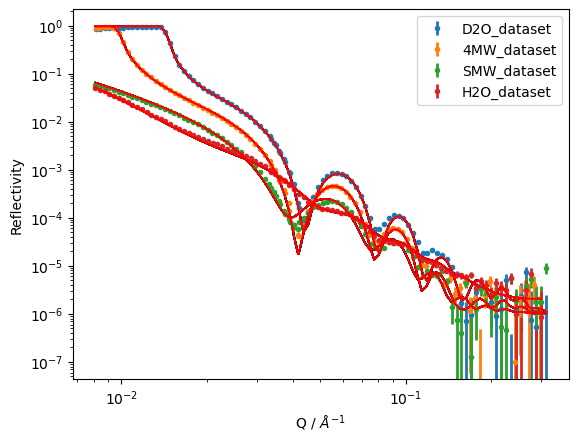

In [21]:
global_objective.plot(samples=200);

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Q / $\AA^{-1}$')
plt.ylabel('Reflectivity')
plt.legend();

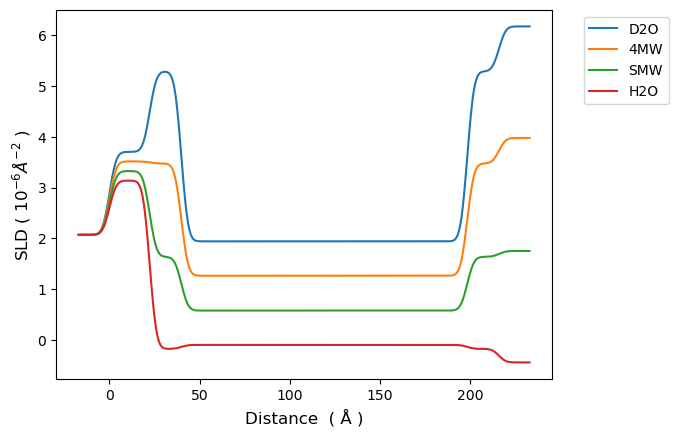

In [22]:
fig2, ax = plt.subplots()
ax.plot(*s_d2o.sld_profile(), label='D2O')
ax.plot(*s_fmw.sld_profile(), label='4MW')
ax.plot(*s_smw.sld_profile(), label='SMW')
ax.plot(*s_h2o.sld_profile(), label='H2O')

ax.set_ylabel("SLD ( $10^{-6} \AA^{-2}$ )", fontsize = 12)
ax.set_xlabel("Distance  ( Å )", fontsize = 12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

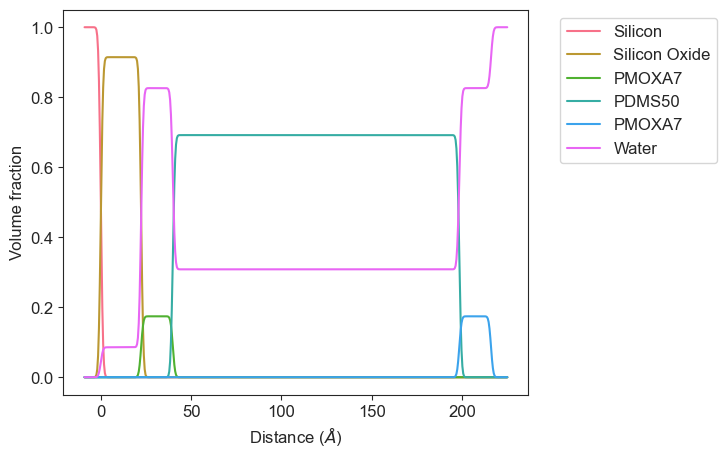

In [23]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set style
sns.set_style('ticks')

# Add your custom labels to this list
custom_labels = ["Silicon", "Silicon Oxide", "PMOXA7", "PDMS50", "PMOXA7", "Water"]  # Example labels

def create_vfp(structure, solvent_slab=-1, roughness=1, labels=None):
    _slabs = structure.slabs().copy()
    
    #Artificially set the roughness of the volume fraction profile to 1 Å to facilitate visualisation
    if roughness is not None:
        _slabs[:, 3] = roughness
        
    # Create an array of hydration values for each slab in the structure
    hydration_values = np.zeros(len(_slabs))

    # Assign hydration values only to the layers of the Paracini component
    hydration_values[1:5] = np.array([ m.sio2_hydration.value,
                                       m.head_hydration.value,
                                       m.tails_hydration.value,
                                       m.head_hydration.value ])
                                                                       
    vf = 1 - hydration_values
    
    if solvent_slab is None:
        nvfp = len(_slabs) + 1
    else:
        nvfp = len(_slabs)
    
    z, sldp = sld_profile(_slabs) 
    vfp = np.zeros((nvfp, len(z)), float)
    
    for i in range(len(_slabs)):
        _slabs[:, 1:3] = 0
        _slabs[i, 1] = vf[i]
        _vfp = sld_profile(_slabs, z=z)[1]
        vfp[i] = _vfp
    
    # fix up the solvent vfp
    _slabs[:, 1] = hydration_values

    if solvent_slab is None:
        _vfp = sld_profile(_slabs, z=z)[1]
        vfp[-1] = _vfp
    else:
        _slabs[solvent_slab, 1] = 1
        _vfp = sld_profile(_slabs, z=z)[1]
        vfp[solvent_slab] = _vfp

    return z, vfp

z, vfp = create_vfp(s_d2o, solvent_slab=-1, labels=custom_labels)

# Get the "Paired" color palette from Seaborn
colors = sns.color_palette('husl', len(vfp))

fig3 = plt.figure(figsize=(6, 5))

for i in range(len(vfp)):
    sns.lineplot(x=z, y=vfp[i], label=custom_labels[i], color=colors[i])
    plt.ylabel('Volume fraction', fontsize=12)
    plt.xlabel('Distance ($\\AA$)', fontsize=12)
    plt.xticks(fontsize=12) 
    plt.yticks(fontsize=12)  

# Adding a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Summary of the Analysis: Values of fitted parameters, fits, SLD and VF plots

In [25]:
#Display only the values that have been fitted plus other useful metrics
fitted_parameters = global_objective.parameters.varying_parameters() # List varying parameters
print(fitted_parameters)
print("number of fitted parameters: ", len(fitted_parameters)) 

number_of_exp_points = len(data_d2o) + len(data_fmw) + len(data_smw) + len(data_h2o) 
print(" Number of experimental points: ", number_of_exp_points)
number_of_fitted_par = len(fitted_parameters)
print(" Number of fitted parameters: ", number_of_fitted_par)

chisquared = objective_d2o.chisqr() + objective_fmw.chisqr() + objective_smw.chisqr() + objective_h2o.chisqr()
print(" chi^2 = ", chisquared)


print(" Reduced chi^2 = ", chisquared / (number_of_exp_points - number_of_fitted_par ))

________________________________________________________________________________
Parameters:      None      
<Parameter:'Common scale factor', value=0.974818 +/- 0.00125, bounds=[0.8, 1.2]>
<Parameter: 'sio2_thick'  , value=22.3368 +/- 0.109, bounds=[8.0, 30.0]>
<Parameter:'sio2_hydration', value=0.085555 +/- 0.00255, bounds=[0.0, 0.2]>
<Parameter: 'sio2_rough'  , value=3.01321 +/- 0.0173, bounds=[3.0, 8.0]>
<Parameter: 'head_thick'  , value=17.5461 +/- 0.135, bounds=[10.0, 50.0]>
<Parameter:'head_hydration', value=0.825978 +/- 0.00164, bounds=[0.0, 1.0]>
<Parameter: 'tails_thick' , value=158.577 +/- 0.0851, bounds=[100.0, 200.0]>
<Parameter:'tails_hydration', value=0.308226 +/- 0.000573, bounds=[0.0, 1.0]>
<Parameter: 'outer_rough' , value=3.00263 +/- 0.00342, bounds=[3.0, 8.0]>
<Parameter:   'D2O SLD'   , value=6.16642 +/- 0.00137, bounds=[6.0, 6.36]>
<Parameter:   '4MW SLD'   , value=3.97413 +/- 0.00143, bounds=[3.8, 4.2]>
<Parameter:   'SMW SLD'   , value=1.75279 +/- 0.00513, bound

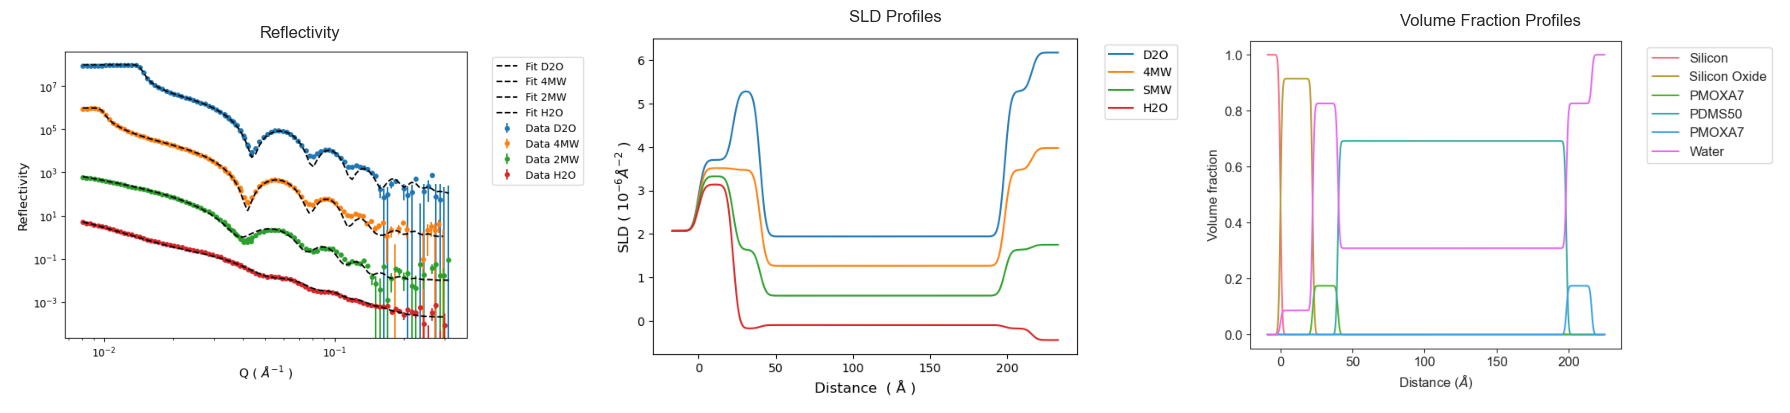

In [26]:
#Create a summary of three figures to summarise the analysis
import matplotlib.pyplot as plt

# Create a new figure for assembling the figures
fig_combined = plt.figure(figsize=(18, 6))  # Adjust the figsize as needed

# Create subplots to arrange the individual figures
ax1 = fig_combined.add_subplot(131)  # 1 row, 3 columns, first subplot
ax2 = fig_combined.add_subplot(132)  # 1 row, 3 columns, second subplot
ax3 = fig_combined.add_subplot(133)  # 1 row, 3 columns, third subplot

# Add the individual figures to the subplots
ax1.imshow(fig1.canvas.renderer.buffer_rgba())
ax2.imshow(fig2.canvas.renderer.buffer_rgba())
ax3.imshow(fig3.canvas.renderer.buffer_rgba())

# Optionally, you can add titles or labels to the subplots
ax1.set_title('Reflectivity')
ax2.set_title('SLD Profiles')
ax3.set_title('Volume Fraction Profiles')

# Remove the axis ticks and labels if desired
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Adjust spacing between subplots
fig_combined.tight_layout()

# Show or save the combined figure
plt.show()